# Simplicial Complexes and Homology
## Simplicial Complexes as Geometric Building Blocks
Any sufficiently nice 2-manifold admits a homeomorphic simplicial complex.
Does not necessarily need to be connected.
A simplicial complex can be combinatorially described by listing its simplices.
## Homology Finds Holes in Shapes
Simplicial complexes can have holes.

Homology is a theory that takes a shape $X$ and for a dimension $n$ outputs a vector space $H_n(X)$ with a basis given by the $n$-dimensional holes of $X$.

The Betti number $\beta _n(X)=\dim H_n(X)$ is the number of $n$-dimensional.
$\beta_0$ is the number of connected components.

# Persistent Homology
## Simplicial Complexes from Data
Suppose we sample finitely many points from an underlying shape in $\mathbb{R}^n$ and we want the homology of the shape.

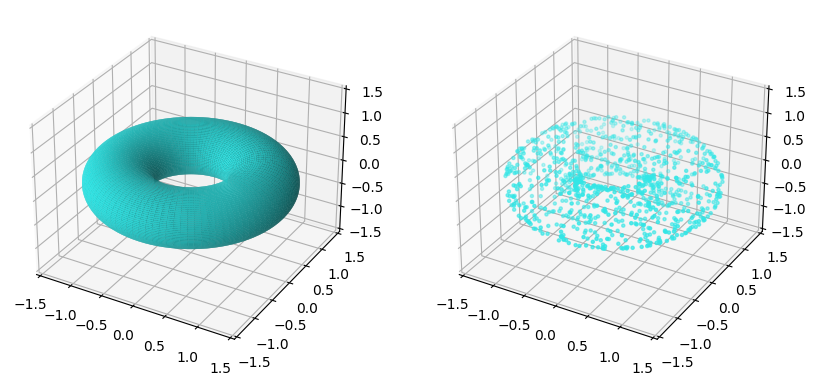

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample

a = 1
b = .5
gamma = np.linspace(0, 2 * np.pi, 100)
theta, gamma = np.meshgrid(gamma, gamma)
X = a*np.cos(theta) + b*np.cos(theta)*np.cos(gamma)
Y = a*np.sin(theta) + b*np.sin(theta)*np.cos(gamma)
Z = b*np.sin(gamma)

fig, axes = plt.subplots(1, 2, figsize = (10, 5), subplot_kw={'projection': '3d'})
axes[0].set_xlim3d(-a*1.5, a*1.5)
axes[0].set_ylim3d(-a*1.5, a*1.5)
axes[0].set_zlim3d(-a*1.5, a*1.5)
axes[0].plot_surface(X, Y, Z, color = (.2,.9,.9), rstride = 1, cstride = 1)

# Sampling
gamma = np.linspace(0, 2 * np.pi, 2000)
sample_size = 1000
gamma_sample = sample(sorted(gamma), sample_size)
theta_sample = sample(sorted(gamma), sample_size)

X = a*np.cos(theta_sample) + b*np.cos(theta_sample)*np.cos(gamma_sample)
Y = a*np.sin(theta_sample) + b*np.sin(theta_sample)*np.cos(gamma_sample)
Z = b*np.sin(gamma_sample)

axes[1].set_xlim3d(-a*1.5, a*1.5)
axes[1].set_ylim3d(-a*1.5, a*1.5)
axes[1].set_zlim3d(-a*1.5, a*1.5)
axes[1].scatter(X, Y, Z, color = (.2,.9,.9, .8), marker= '.', s=20)



Persistent homology constructs a filtration, that is, a sequence of simplicial complexes $\{\mathcal{K}_t\}_{t\in\mathbb{R}}$ such that $\mathcal{K}_s\subseteq\mathcal{K}_t$ when $s\leq t$.
## Barcodes and Persistence Diagrams
Barcodes is a multiset of bars that keeps track of the births and deaths of holes of a given dimension as $t$ increases.

Let $X\subseteq\mathbb{R}^n$ be a point cloud.
For $x\in X$ write $B(x,r)$ for $\{y\in\mathbb{R}^n:|x-y|\leq r\}$.
The Čech complex $\check{C}(X,r)$ contains the $n$-simplex $[x_0,x_1, ...,x_n]$ iff: $$\bigcap_{i=0}^{n}B(x_i,r)\neq \emptyset$$

Vietoris-Rips (VR) complexes approximate Čech complexes.
$\text{VR}(X,r)$ contains the $n$-simplex $[x_0,x_1, ...,x_n]$ iff:
$$
B(x_i,r)\cap B(x_j,r)\neq \emptyset
$$
$\forall i,j\in[0,n]$.

$\check{C}(X,r)\subseteq\text{VR}(X,r)$

Persistence diagrams are multisets of 2D points whose coordinates correspond to the birth and death of bars in a barcode.

The persistence of a bar $(b,d)$ is its length $d-b$.
More persistent bars are signals, others are noise.

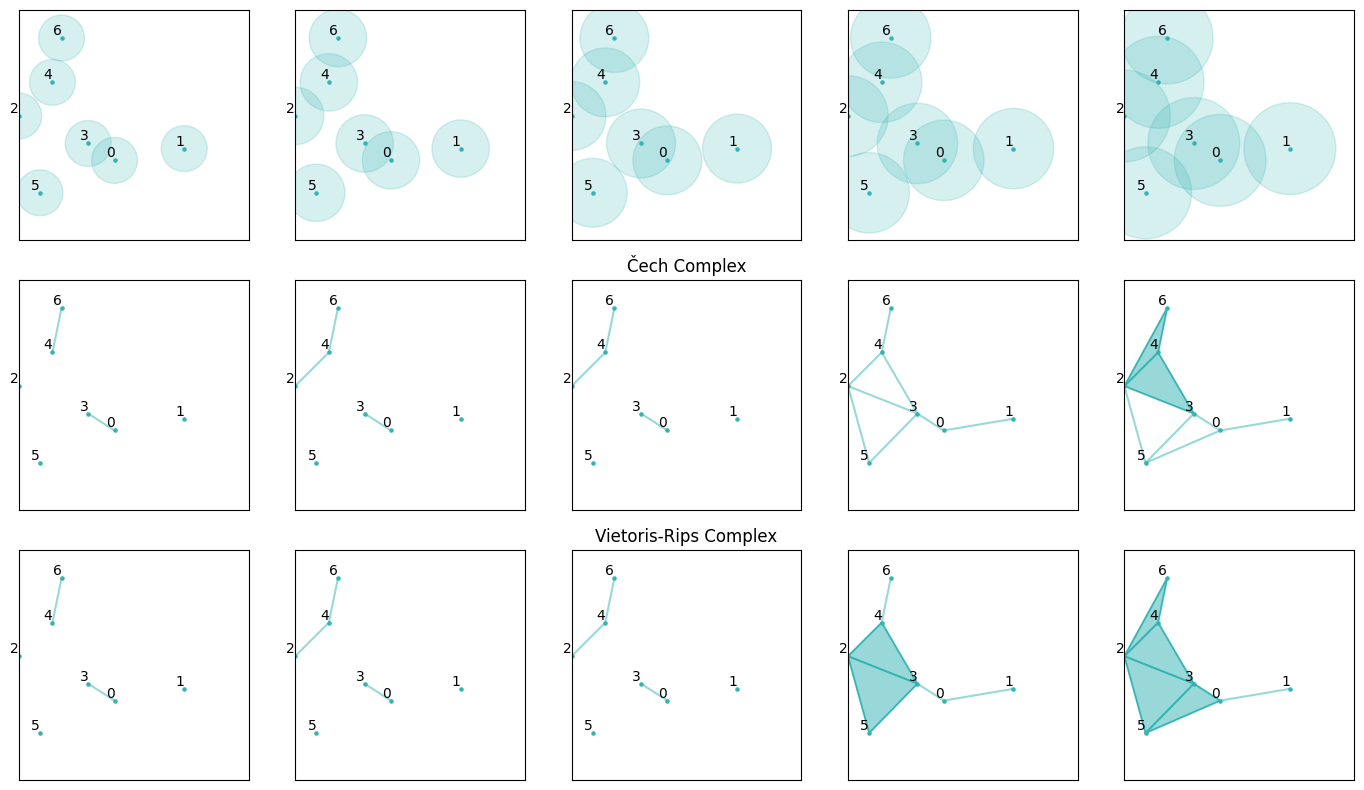

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from itertools import combinations


def calculate_distances(points):
  num_points, dim = points.shape
  points_ = np.expand_dims(points, axis = 0)
  b = np.tile(points_, reps = (num_points, 1, 1))
  a = np.zeros_like(b)

  for i in range(num_points):
    a[i, :, :] = np.roll(points, shift = -i, axis = 0)

  ba = b-a
  for i in range(num_points):
    ba[:, i, :] = np.roll(ba[:, i, :], shift = i, axis = 0)

  d = np.apply_along_axis(func1d = lambda v:np.linalg.norm(v), axis=-1, arr = ba)
  # d[i, j] == np.linalg.norm(xy[j] - xy[i])
  return d

np.random.seed(1)
num_points = 7
x = np.random.rand(num_points)
y = np.random.rand(num_points)
xy = np.stack([x,y], axis = -1)
d = calculate_distances(xy)

radii = 5
r_ = np.linspace(.1, .2, radii)
fig, axes = plt.subplots(3, radii, figsize = (14, 8))
for j in range(radii):
  r = r_[j]
  for i in range(3):
    axes[i, j].set_aspect('equal', adjustable='box')
    axes[i, j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].set_xlim(0, 1)
    axes[i, j].set_ylim(0, 1)
    axes[i, j].scatter(x, y, color = (.2,.7,.7, 1), s = 5)
    for point in range(num_points):
      label = f'{point}'
      axes[i, j].text(x[point], y[point], label, fontsize=10, ha='right', va='bottom')


  for point in range(num_points):
    axes[0, j].add_patch(plt.Circle((x[point], y[point]), radius=r, color=(.2,.7,.7, .2), fill=True))

  threshold_matrix = (d<2*r)&(d>0)
  edges = np.transpose(np.where(threshold_matrix))

  if len(edges) == 0:
    continue
  else:
    half_edges_list = edges.tolist()
    edges_list = edges.tolist()
    [edges_list.remove(edge[::-1]) for edge in half_edges_list if edge in edges_list]
    edges = np.reshape(np.transpose(xy[np.array(edges_list)], (0,2,1)), newshape = (-1, 2))

    axes[1, j].plot(*edges, color = (.2,.7,.7, .5))
    axes[2, j].plot(*edges, color = (.2,.7,.7, .5))

    edge_arr = np.array(edges_list)
    triangles = []
    for point in range(num_points):
      connected_edges = edge_arr[edge_arr[:, 0] == point, :]
      ends = combinations(connected_edges[:,1], 2)
      for connected_points in ends:
        if list(connected_points) in edges_list:
          triangles.append([point, *connected_points])

    for triangle in triangles:
      axes[2, j].add_patch(Polygon(xy[triangle], closed=True, edgecolor = (.2,.7,.7, 1), facecolor= (.2,.7,.7, .5)))
      centroid = np.array([np.mean(x[triangle]), np.mean(y[triangle])])
      if all(np.linalg.norm(xy[triangle]-centroid, axis=1)<r):
        axes[1, j].add_patch(Polygon(xy[triangle], closed=True, edgecolor = (.2,.7,.7, 1), facecolor= (.2,.7,.7, .5)))

axes[1, 2].set_title('Čech Complex')
axes[2, 2].set_title('Vietoris-Rips Complex')
plt.tight_layout()
plt.show()

In [11]:
from queue import Queue
edges_queue = Queue()
half_edges_arr = np.array(half_edges_list)
for edge in half_edges_list:
  edges_queue.put(edge)

#print(edges_queue.queue)
max_iter = 20
iter = 0
loops = set()
while len(edges_queue.queue)>0 & iter<max_iter:
  iter =+ 1
  edge = edges_queue.get()
  #print(edge)
  other_edges = half_edges_arr[np.logical_not((half_edges_arr == edge[-2:][::-1]).all(axis=1))]
  connections = other_edges[other_edges[:, 0] == edge[-1]]
  for connection in connections:
    #print('conn:', connection)
    new_conn = [*edge, connection[1]]
    #print('new_conn', new_conn)
    unique_edges, counts = np.unique(new_conn, return_counts=True)
    if len(unique_edges) < len(new_conn):
      inter = unique_edges[counts > 1]
      inter_id = np.where(new_conn == inter)[0]
      loop = new_conn[inter_id[0]:inter_id[1]+1]
      loops.add(tuple(loop))
    else:
      edges_queue.put(new_conn)
loops

{(0, 3, 2, 5, 0),
 (0, 3, 4, 2, 5, 0),
 (0, 3, 4, 6, 2, 5, 0),
 (0, 3, 5, 0),
 (0, 5, 2, 3, 0),
 (0, 5, 2, 4, 3, 0),
 (0, 5, 2, 6, 4, 3, 0),
 (0, 5, 3, 0),
 (2, 3, 0, 5, 2),
 (2, 3, 4, 2),
 (2, 3, 4, 6, 2),
 (2, 3, 5, 2),
 (2, 4, 3, 0, 5, 2),
 (2, 4, 3, 2),
 (2, 4, 3, 5, 2),
 (2, 4, 6, 2),
 (2, 5, 0, 3, 2),
 (2, 5, 0, 3, 4, 2),
 (2, 5, 0, 3, 4, 6, 2),
 (2, 5, 3, 2),
 (2, 5, 3, 4, 2),
 (2, 5, 3, 4, 6, 2),
 (2, 6, 4, 2),
 (2, 6, 4, 3, 0, 5, 2),
 (2, 6, 4, 3, 2),
 (2, 6, 4, 3, 5, 2),
 (3, 0, 5, 2, 3),
 (3, 0, 5, 2, 4, 3),
 (3, 0, 5, 2, 6, 4, 3),
 (3, 0, 5, 3),
 (3, 2, 4, 3),
 (3, 2, 5, 0, 3),
 (3, 2, 5, 3),
 (3, 2, 6, 4, 3),
 (3, 4, 2, 3),
 (3, 4, 2, 5, 0, 3),
 (3, 4, 2, 5, 3),
 (3, 4, 6, 2, 3),
 (3, 4, 6, 2, 5, 0, 3),
 (3, 4, 6, 2, 5, 3),
 (3, 5, 0, 3),
 (3, 5, 2, 3),
 (3, 5, 2, 4, 3),
 (3, 5, 2, 6, 4, 3),
 (4, 2, 3, 4),
 (4, 2, 5, 0, 3, 4),
 (4, 2, 5, 3, 4),
 (4, 2, 6, 4),
 (4, 3, 0, 5, 2, 4),
 (4, 3, 0, 5, 2, 6, 4),
 (4, 3, 2, 4),
 (4, 3, 2, 6, 4),
 (4, 3, 5, 2, 4),
 (4, 3, 5, 2, 6, 4)

In [36]:
edge_arr

array([[0, 1],
       [0, 3],
       [0, 5],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [3, 4],
       [3, 5],
       [4, 6]])

In [44]:
rev_edge_arr = np.zeros_like(edge_arr)
rev_edge_arr[:, 0] = edge_arr[:, 1]
rev_edge_arr[:, 1] = edge_arr[:, 0]

loops_as_edges = set()
for loop in loops:
  print(loop)
  print('edges:')
  edge_loop = []
  for point in range(len(loop)-1):
    edge_ = loop[point:point+2]
    edge_id = np.where(np.all(rev_edge_arr == edge_, axis = 1)|np.all(edge_arr == edge_, axis = 1))[0][0]
    edge_loop.append(edge_id)
    print(edge_, edge_id)

  loops_as_edges.add(tuple(edge_loop))

  print('\n')

(4, 2, 5, 3, 4)
edges:
(4, 2) 4
(2, 5) 5
(5, 3) 8
(3, 4) 7


(3, 0, 5, 2, 4, 3)
edges:
(3, 0) 1
(0, 5) 2
(5, 2) 5
(2, 4) 4
(4, 3) 7


(3, 2, 5, 3)
edges:
(3, 2) 3
(2, 5) 5
(5, 3) 8


(4, 3, 5, 2, 4)
edges:
(4, 3) 7
(3, 5) 8
(5, 2) 5
(2, 4) 4


(3, 5, 2, 3)
edges:
(3, 5) 8
(5, 2) 5
(2, 3) 3


(5, 2, 4, 3, 5)
edges:
(5, 2) 5
(2, 4) 4
(4, 3) 7
(3, 5) 8


(3, 4, 6, 2, 5, 0, 3)
edges:
(3, 4) 7
(4, 6) 9
(6, 2) 6
(2, 5) 5
(5, 0) 2
(0, 3) 1


(3, 0, 5, 2, 3)
edges:
(3, 0) 1
(0, 5) 2
(5, 2) 5
(2, 3) 3


(2, 5, 0, 3, 2)
edges:
(2, 5) 5
(5, 0) 2
(0, 3) 1
(3, 2) 3


(3, 0, 5, 3)
edges:
(3, 0) 1
(0, 5) 2
(5, 3) 8


(5, 2, 6, 4, 3, 0, 5)
edges:
(5, 2) 5
(2, 6) 6
(6, 4) 9
(4, 3) 7
(3, 0) 1
(0, 5) 2


(0, 3, 5, 0)
edges:
(0, 3) 1
(3, 5) 8
(5, 0) 2


(5, 3, 4, 2, 5)
edges:
(5, 3) 8
(3, 4) 7
(4, 2) 4
(2, 5) 5


(3, 5, 2, 6, 4, 3)
edges:
(3, 5) 8
(5, 2) 5
(2, 6) 6
(6, 4) 9
(4, 3) 7


(0, 3, 4, 6, 2, 5, 0)
edges:
(0, 3) 1
(3, 4) 7
(4, 6) 9
(6, 2) 6
(2, 5) 5
(5, 0) 2


(6, 2, 4, 6)
edges:
(6, 2) 6
(2, 4) 4

In [49]:
loopset = set()
for loop in loops_as_edges:
  loopset.add(tuple(sorted(loop)))

loopset

{(1, 2, 3, 5),
 (1, 2, 4, 5, 7),
 (1, 2, 5, 6, 7, 9),
 (1, 2, 8),
 (3, 4, 7),
 (3, 5, 8),
 (3, 6, 7, 9),
 (4, 5, 7, 8),
 (4, 6, 9),
 (5, 6, 7, 8, 9)}

In [12]:
loopset = set()
for loop in loops:
    loopset.add(tuple(sorted(loop[:-1])))

loopset

{(0, 2, 3, 4, 5),
 (0, 2, 3, 4, 5, 6),
 (0, 2, 3, 5),
 (0, 3, 5),
 (2, 3, 4),
 (2, 3, 4, 5),
 (2, 3, 4, 5, 6),
 (2, 3, 4, 6),
 (2, 3, 5),
 (2, 4, 6)}